<a href="https://colab.research.google.com/github/rogerpanel/CV/blob/main/GAN_Evasion_XII_DQN%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Incorporating RL - DQN

In [ ]:
# pip install tensorflow tensorflow-addons gym numpy


In [ ]:
# Preprocessing CICIDS2017 - Dataset

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import gc
import tensorflow.keras.mixed_precision as mixed_precision


# PREPROCESSING

In [ ]:
# Function to save dataset
def save_dataset(X_train, X_test, y_train, y_test, scaler, label_encoder, file_path):
    try:
        np.savez(file_path,
                 X_train=X_train, X_test=X_test,
                 y_train=y_train, y_test=y_test,
                 scaler_mean=scaler.mean_, scaler_scale=scaler.scale_,
                 label_encoder_classes=label_encoder.classes_)
        print(f"Dataset saved to {file_path}")
    except Exception as e:
        print(f"Error saving dataset: {e}")

# Function to load dataset
def load_dataset(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        X_train, X_test = data['X_train'], data['X_test']
        y_train, y_test = data['y_train'], data['y_test']

        scaler = StandardScaler()
        scaler.mean_ = data['scaler_mean']
        scaler.scale_ = data['scaler_scale']

        label_encoder = LabelEncoder()
        label_encoder.classes_ = data['label_encoder_classes']

        print(f"Dataset loaded from {file_path}")
        return X_train, X_test, y_train, y_test, scaler, label_encoder
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None, None, None, None, None

# Function to read data in chunks and handle data types
def read_data_in_chunks(file_path, chunk_size=10000):
    for chunk in pd.read_csv(file_path, dtype='unicode', chunksize=chunk_size, on_bad_lines='warn'):
        try:
            # Convert data types to more memory-efficient ones
            for column in chunk.columns:
                if column != ' Label':  # Skip the label column
                    chunk[column] = pd.to_numeric(chunk[column], errors='coerce')
            yield chunk
        except MemoryError:
            print(f"MemoryError encountered. Skipping chunk and clearing memory.")
            del chunk
            gc.collect()
            continue

# Function to safely clip and scale data
def safe_scale(data, scaler=None, clip_range=(-1e3, 1e3)):
    # Fill NaN values with 0 (or another appropriate value)
    data = data.fillna(0)

    # Convert all columns to numeric type
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    # Fill any remaining NaN values (from coerce) with 0
    data = data.fillna(0)

    # Now it's safe to clip and scale
    clipped = data.clip(*clip_range)
    if scaler is None:
        scaler = StandardScaler()
        return scaler.fit_transform(clipped), scaler
    else:
        return scaler.transform(clipped), scaler

# Check if dataset checkpoint exists
dataset_file = 'dataset_checkpoint_3.npz'
X_train, X_test, y_train, y_test, scaler, label_encoder = load_dataset(dataset_file)

if X_train is not None:
    print("Dataset loaded successfully. Proceeding with model training.")
else:
    print("Processing dataset...")
    # Step 1: Identify all possible labels, including 'Unknown'
    all_labels = set()
    for chunk in read_data_in_chunks('/content/CICID_2017_dataset.csv'):
        all_labels.update(chunk[' Label'].dropna().unique())
    all_labels.add('Unknown')

    # Initialize label encoder with all possible labels
    label_encoder = LabelEncoder()
    label_encoder.fit(list(all_labels))

    # Initialize empty lists to accumulate data
    X_list = []
    y_list = []
    scaler = None

    # Step 2: Read and process data in chunks again
    for chunk in read_data_in_chunks('/content/CICID_2017_dataset.csv'):
        # Handle problematic labels
        chunk[' Label'] = chunk[' Label'].apply(lambda x: str(x) if pd.notna(x) else "Unknown")

        # Check for any labels not seen before and add them to the encoder if necessary
        unknown_labels = set(chunk[' Label'].unique()) - set(label_encoder.classes_)
        if unknown_labels:
            all_classes = list(label_encoder.classes_) + list(unknown_labels)
            label_encoder = LabelEncoder()
            label_encoder.fit(all_classes)

        # Encode labels
        chunk[' Label'] = label_encoder.transform(chunk[' Label'])

        # Split datasets into features and labels
        X_chunk = chunk.drop(' Label', axis=1)
        y_chunk = chunk[' Label']

        # Scale the data safely
        if scaler is None:
            X_chunk_scaled, scaler = safe_scale(X_chunk)
        else:
            X_chunk_scaled, _ = safe_scale(X_chunk, scaler)

        # Accumulate the scaled data and labels
        X_list.append(X_chunk_scaled)
        y_list.append(y_chunk)

        # Clear chunk data
        del chunk, X_chunk, y_chunk, X_chunk_scaled
        gc.collect()

    # Concatenate all chunks
    X = np.vstack(X_list)
    y = np.hstack(y_list)

    # Clear unused variables
    del X_list, y_list
    gc.collect()

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Clear unused variables
    del X, y
    gc.collect()

    # Save the processed dataset
    save_dataset(X_train, X_test, y_train, y_test, scaler, label_encoder, dataset_file)

# Inspect label_encoder.classes_
print("Label classes:")
print(label_encoder.classes_)

# Proceed with model training...

Error loading dataset: [Errno 2] No such file or directory: 'dataset_checkpoint_3.npz'
Processing dataset...
Dataset saved to dataset_checkpoint_3.npz
Label classes:
['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'Heartbleed' 'Infiltration' 'PortScan' 'Unknown']


# BASELINE IDS NN MODEL

In [ ]:
# Applying Data Generator for processing memory mgt



# Adjust DataGenerator for safer memory usage
class DataGenerator(Sequence):
    def __init__(self, X, y, autoencoder=None, batch_size=256, shuffle=True):
        self.X = X if isinstance(X, np.ndarray) else X.values.astype(np.float32)
        self.y = y if isinstance(y, np.ndarray) else y.values
        self.autoencoder = autoencoder
        self.batch_size = min(batch_size, len(self.X))  # Adjust batch size if it's larger than the dataset
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        if self.autoencoder:
            try:
                X_batch = self.autoencoder.predict(X_batch, batch_size=self.batch_size)
            except tf.errors.ResourceExhaustedError:
                print("Resource exhausted. Reducing batch size.")
                self.batch_size //= 2
                return self.__getitem__(index)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Build the Baseline IDS Neural Network Model

# Define the baseline neural network model
def build_nn_model(input_dim, num_classes):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
nn_model = build_nn_model(input_dim, num_classes)
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the baseline model with early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
train_generator = DataGenerator(X_train, y_train, batch_size=256)
test_generator = DataGenerator(X_test, y_test, batch_size=256, shuffle=False)
nn_model.fit(train_generator, epochs=50, callbacks=[early_stopping], validation_data=test_generator)

# Evaluate on original test data
y_pred = np.argmax(nn_model.predict(X_test), axis=1)
valid_classes = [str(class_name) for class_name in label_encoder.classes_ if pd.notna(class_name)]
all_classes = np.arange(len(valid_classes))

print("Baseline Neural Network Model - Original Test Data")
print(classification_report(y_test, y_pred, labels=all_classes, target_names=valid_classes))
print("Original Test Data Accuracy:", accuracy_score(y_test, y_pred))



Epoch 1/50
6921/6921 [==============================] - 34s 5ms/step - loss: 0.0248 - accuracy: 0.9936 - val_loss: 0.0116 - val_accuracy: 0.9968
Epoch 2/50
6921/6921 [==============================] - 30s 4ms/step - loss: 0.0107 - accuracy: 0.9971 - val_loss: 0.0094 - val_accuracy: 0.9975
Epoch 3/50
6921/6921 [==============================] - 30s 4ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0085 - val_accuracy: 0.9976
Epoch 4/50
6921/6921 [==============================] - 31s 5ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0079 - val_accuracy: 0.9977
Epoch 5/50
6921/6921 [==============================] - 33s 5ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0085 - val_accuracy: 0.9975
Epoch 6/50
6921/6921 [==============================] - 38s 6ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.0080 - val_accuracy: 0.9977
Epoch 7/50
6921/6921 [==============================] - 33s 5ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0081 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    334554
             Bot       1.00      0.40      0.57       415
            DDoS       1.00      1.00      1.00     25490
   DoS GoldenEye       0.99      0.99      0.99      2013
        DoS Hulk       0.99      1.00      1.00     46382
DoS Slowhttptest       0.96      0.99      0.97      1154
   DoS slowloris       1.00      0.96      0.98      1150
      Heartbleed       0.00      0.00      0.00         1
    Infiltration       0.67      0.67      0.67         3
        PortScan       0.99      1.00      1.00     31732
         Unknown       0.00      0.00      0.00         0

       micro avg       1.00      1.00      1.00    442894
       macro avg       0.78      0.73      0.74    442894
    weighted avg       1.00      1.00      1.00    442894

Original Test Data Accuracy: 0.9978392120913808


In [ ]:
#Check the unique classes in the y label and and predictied label

# Check the unique classes in the true labels and predicted labels
unique_true_labels = np.unique(y_test)
unique_predicted_labels = np.unique(y_pred)

print(f"Unique classes in true labels: {unique_true_labels}")
print(f"Unique classes in predicted labels: {unique_predicted_labels}")


Unique classes in true labels: [0 1 2 3 4 5 6 7 8 9]
Unique classes in predicted labels: [0 1 2 3 4 5 6 8 9]


# Build the adversarial examples starting with cGAN

In [ ]:
# Define the GAN models
def build_generator(input_dim, num_classes, output_dim):
    noise_input = Input(shape=(input_dim,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(output_dim, activation='tanh')(x)
    model = Model([noise_input, label_input], output)
    return model

def build_discriminator(input_dim, num_classes):
    packet_input = Input(shape=(input_dim,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([packet_input, label_input])
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model([packet_input, label_input], output)
    return model

def build_gan(generator, discriminator):
    noise_input, label_input = generator.input
    packet_output = generator.output
    gan_output = discriminator([packet_output, label_input])
    model = Model([noise_input, label_input], gan_output)
    return model

generator = build_generator(100, num_classes, input_dim)
discriminator = build_discriminator(input_dim, num_classes)
gan = build_gan(generator, discriminator)

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='adam')


# Train the GAN
def train_gan(generator, discriminator, gan, data, labels, epochs=1000, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        real_indices = np.random.randint(0, data.shape[0], half_batch)
        real_packets = data[real_indices]
        real_labels = labels[real_indices]

        noise = np.random.normal(0, 1, (half_batch, 100))
        random_labels = np.eye(num_classes)[np.random.randint(0, num_classes, half_batch)]
        fake_packets = generator.predict([noise, random_labels])

        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch([real_packets, real_labels], np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch([fake_packets, random_labels], np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        random_labels = np.eye(num_classes)[np.random.randint(0, num_classes, batch_size)]
        discriminator.trainable = False
        g_loss = gan.train_on_batch([noise, random_labels], np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}] [G loss: {g_loss}]")

# Before starting the GAN training
gan_checkpoint_file = 'gan_checkpoint_3.h5'
if os.path.exists(gan_checkpoint_file):
    print("Loading GAN from checkpoint...")
    generator.load_weights(gan_checkpoint_file)
else:
    print("Training GAN...")
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_train_one_hot = np.eye(num_classes)[y_train_encoded]
    train_gan(generator, discriminator, gan, X_train, y_train_one_hot, epochs=1000)
    generator.save_weights(gan_checkpoint_file)




Training GAN...
1/1 [==============================] - 0s 96ms/step
0 [D loss: 0.8331384062767029 | D accuracy: 10.9375] [G loss: 0.6179205179214478]
1/1 [==============================] - 0s 20ms/step
100 [D loss: 0.08732033893465996 | D accuracy: 95.3125] [G loss: 6.241657257080078]
1/1 [==============================] - 0s 15ms/step
200 [D loss: 0.0035599584225565195 | D accuracy: 100.0] [G loss: 8.187685012817383]
1/1 [==============================] - 0s 22ms/step
300 [D loss: 0.000659177741908934 | D accuracy: 100.0] [G loss: 10.326934814453125]
1/1 [==============================] - 0s 15ms/step
400 [D loss: 1.7814387547332444e-05 | D accuracy: 100.0] [G loss: 14.019485473632812]
1/1 [==============================] - 0s 16ms/step
500 [D loss: 1.0896100244295326e-08 | D accuracy: 100.0] [G loss: 19.92635154724121]
1/1 [==============================] - 0s 18ms/step
600 [D loss: 1.0146546635003695e-05 | D accuracy: 100.0] [G loss: 19.945194244384766]
1/1 [========================

# 2. Generating FGSM and PGD Datasets


In [ ]:
# Function to safely generate adversarial examples
def safe_generate_adversarial(method, model, X, y, **kwargs):
    try:
        if method == 'fgsm':
            return fgsm_attack(model, X, y, **kwargs)
        elif method == 'pgd':
            return pgd_attack(model, X, y, **kwargs)
        elif method == 'gan':
            noise = np.random.normal(0, 1, (X.shape[0], kwargs['noise_dim'])).astype(np.float32)
            labels = kwargs.get('labels')
            return generator.predict([noise, labels], batch_size=64)
    except tf.errors.ResourceExhaustedError:
        print(f"Resource exhausted during {method} generation. Reducing batch size.")
        kwargs['batch_size'] = kwargs.get('batch_size', 64) // 2
        return safe_generate_adversarial(method, model, X, y, **kwargs)

# Define adversarial attack functions
@tf.function
def fgsm_attack(model, data, labels, epsilon=0.01):
    data = tf.convert_to_tensor(data, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    with tf.GradientTape() as tape:
        tape.watch(data)
        predictions = model(data)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, data)
    perturbation = epsilon * tf.sign(gradient)
    adversarial_data = data + perturbation
    return adversarial_data.numpy()

@tf.function
def pgd_attack(model, X, y, epsilon=0.1, alpha=0.01, num_iter=10):
    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.int32)
    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            prediction = model(X_adv)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, prediction)
        gradient = tape.gradient(loss, X_adv)
        signed_grad = tf.sign(gradient)
        X_adv = X_adv + alpha * signed_grad
        X_adv = tf.clip_by_value(X_adv, X - epsilon, X + epsilon)
        X_adv = tf.clip_by_value(X_adv, 0, 1)
    return X_adv.numpy()



#generate the three adversarial examples

In [ ]:
# Function to safely generate adversarial examples
def safe_generate_adversarial(method, model, X, y, **kwargs):
    try:
        if method == 'fgsm':
            X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
            y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
            with tf.GradientTape() as tape:
                tape.watch(X_tensor)
                loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, model(X_tensor))
            gradient = tape.gradient(loss, X_tensor)
            perturbation = kwargs['epsilon'] * tf.sign(gradient)
            return (X_tensor + perturbation).numpy()
        elif method == 'pgd':
            X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
            y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
            X_adv = tf.identity(X_tensor)
            for _ in range(kwargs['num_iter']):
                with tf.GradientTape() as tape:
                    tape.watch(X_adv)
                    loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, model(X_adv))
                gradient = tape.gradient(loss, X_adv)
                signed_grad = tf.sign(gradient)
                X_adv = X_adv + kwargs['alpha'] * signed_grad
                X_adv = tf.clip_by_value(X_adv, X - kwargs['epsilon'], X + kwargs['epsilon'])
            return X_adv.numpy()
        elif method == 'gan':
            num_samples = kwargs.get('num_samples')
            if num_samples is None:
                raise ValueError("For 'gan' method, 'num_samples' must be provided.")
            noise = np.random.normal(0, 1, (num_samples, kwargs['noise_dim'])).astype(np.float32)
            labels = kwargs.get('labels')
            if labels is None:
                raise ValueError("For 'gan' method, 'labels' must be provided.")
            return generator.predict([noise, labels], batch_size=256)
    except tf.errors.ResourceExhaustedError:
        print(f"Resource exhausted during {method} generation. Reducing batch size.")
        kwargs['batch_size'] = kwargs.get('batch_size', 256) // 2
        return safe_generate_adversarial(method, model, X, y, **kwargs)

# Before generating adversarial examples
adv_examples_file = 'adv_examples_3.npz'
if os.path.exists(adv_examples_file):
    print("Loading adversarial examples from checkpoint...")
    data = np.load(adv_examples_file)
    adv_examples_fgsm = data['fgsm']
    adv_examples_pgd = data['pgd']
    adv_examples_gan = data['gan']
else:
    print("Generating adversarial examples...")
    # Generate adversarial examples safely
    noise_dim = 100
    random_labels = np.eye(num_classes)[np.random.randint(0, num_classes, X_test.shape[0])]
    adv_examples_fgsm = safe_generate_adversarial('fgsm', nn_model, X_test, y_test, epsilon=0.01)
    adv_examples_pgd = safe_generate_adversarial('pgd', nn_model, X_test, y_test, epsilon=0.1, alpha=0.01, num_iter=20)
    adv_examples_gan = safe_generate_adversarial('gan', None, None, None, noise_dim=noise_dim, labels=random_labels, num_samples=X_test.shape[0])

    np.savez(adv_examples_file, fgsm=adv_examples_fgsm, pgd=adv_examples_pgd, gan=adv_examples_gan)




Generating adversarial examples...
1731/1731 [==============================] - 3s 1ms/step


# Evaluation of Adversarial examples on Baseline IDS DNN model

In [ ]:


def safe_evaluate(model, data, labels, batch_size=256, name="Dataset"):
    try:
        y_pred = model.predict(data, batch_size=batch_size)
        y_pred_classes = np.argmax(y_pred, axis=1)
        print(f"Model - {name}")

        # Get all unique classes from both y_true and y_pred
        all_classes = np.unique(np.concatenate([labels, y_pred_classes]))

        # Map classes to a continuous range
        class_map = {cls: i for i, cls in enumerate(all_classes)}
        mapped_true = np.array([class_map[cls] for cls in labels])
        mapped_pred = np.array([class_map[cls] for cls in y_pred_classes])

        # Get class names, handling potential mismatches and ensuring they're strings
        class_names = []
        for cls in all_classes:
            if cls < len(label_encoder.classes_):
                class_name = label_encoder.classes_[cls]
                if pd.isna(class_name):
                    class_names.append(f"Unknown_Class_{cls}")
                else:
                    class_names.append(str(class_name))  # Convert to string
            else:
                class_names.append(f"Unknown_Class_{cls}")

        print(classification_report(mapped_true, mapped_pred, labels=range(len(class_names)), target_names=class_names))
        print("Accuracy:", accuracy_score(labels, y_pred_classes))
    except tf.errors.ResourceExhaustedError:
        print(f"Resource exhausted during evaluation on {name}. Reducing batch size.")
        safe_evaluate(model, data, labels, batch_size // 2, name)

# Evaluate models safely
for name, data in [
    ("Original Test Data", X_test),
    ("GAN Adversarial Examples", adv_examples_gan),
    ("FGSM Adversarial Examples", adv_examples_fgsm),
    ("PGD Adversarial Examples", adv_examples_pgd)
]:
    safe_evaluate(nn_model, data, y_test, name=name)
    # Clear memory after each evaluation
    tf.keras.backend.clear_session()
    gc.collect()


1731/1731 [==============================] - 3s 2ms/step
Model - Original Test Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    334554
           1       1.00      0.40      0.57       415
           2       1.00      1.00      1.00     25490
           3       0.99      0.99      0.99      2013
           4       0.99      1.00      1.00     46382
           5       0.96      0.99      0.97      1154
           6       1.00      0.96      0.98      1150
           7       0.00      0.00      0.00         1
           8       0.67      0.67      0.67         3
           9       0.99      1.00      1.00     31732

    accuracy                           1.00    442894
   macro avg       0.86      0.80      0.82    442894
weighted avg       1.00      1.00      1.00    442894

Accuracy: 0.9978392120913808
1731/1731 [==============================] - 3s 2ms/step
Model - GAN Adversarial Examples


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.76      1.00      0.86    334554
           1       0.00      0.00      0.00       415
           2       0.00      0.00      0.00     25490
           3       0.00      0.00      0.00      2013
           4       0.00      0.00      0.00     46382
           5       0.00      0.00      0.00      1154
           6       0.00      0.00      0.00      1150
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00     31732

    accuracy                           0.76    442894
   macro avg       0.08      0.10      0.09    442894
weighted avg       0.57      0.76      0.65    442894

Accuracy: 0.7553816488821253
1731/1731 [==============================] - 3s 2ms/step
Model - FGSM Adversarial Examples


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    334554
           1       0.99      0.40      0.57       415
           2       1.00      1.00      1.00     25490
           3       0.99      0.99      0.99      2013
           4       0.99      1.00      0.99     46382
           5       0.96      0.99      0.97      1154
           6       1.00      0.96      0.98      1150
           7       0.00      0.00      0.00         1
           8       0.50      0.67      0.57         3
           9       0.99      1.00      1.00     31732

    accuracy                           1.00    442894
   macro avg       0.84      0.80      0.81    442894
weighted avg       1.00      1.00      1.00    442894

Accuracy: 0.997527625120232
1731/1731 [==============================] - 4s 2ms/step
Model - PGD Adversarial Examples


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.93      0.90    334554
           1       0.17      0.33      0.23       415
           2       0.90      0.37      0.52     25490
           3       0.50      0.62      0.55      2013
           4       0.81      0.71      0.76     46382
           5       0.17      0.14      0.15      1154
           6       0.02      0.10      0.03      1150
           7       0.00      0.00      0.00         1
           8       0.03      0.33      0.05         3
           9       0.52      0.44      0.48     31732

    accuracy                           0.83    442894
   macro avg       0.40      0.40      0.37    442894
weighted avg       0.84      0.83      0.83    442894

Accuracy: 0.8328968105235113


# Building the robust adversarial Model

In [ ]:
# first build the Autoencoder, the robust Neural Network, and RL - DQN
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import gc

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define the autoencoder
def build_autoencoder(input_dim):
    model = Sequential([
        Dense(64, input_shape=(input_dim,), activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='sigmoid', dtype='float32')  # Ensure final layer outputs are float32
    ])
    return model

# Define the policy network for reinforcement learning
def build_policy_network(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(input_dim, activation='linear')  # Outputs adjustments to autoencoder's weights
    ])
    return model

# Placeholder for input_dim and num_classes
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Initialize autoencoder and policy network
autoencoder = build_autoencoder(input_dim)
policy_network = build_policy_network(input_dim)

# Define experience replay buffer
class ExperienceReplay:
    def __init__(self, max_size):
        self.buffer = []
        self.max_size = max_size

    def add(self, experience):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Define reward mechanism
def compute_reward(true_labels, predicted_labels):
    return np.sum(true_labels == predicted_labels) / len(true_labels)
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import gc

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define the autoencoder
def build_autoencoder(input_dim):
    model = Sequential([
        Dense(64, input_shape=(input_dim,), activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='sigmoid', dtype='float32')  # Ensure final layer outputs are float32
    ])
    return model

# Define the policy network for reinforcement learning
def build_policy_network(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(input_dim, activation='linear')  # Outputs adjustments to autoencoder's weights
    ])
    return model

# Define a simple classifier for demonstration purposes
def build_classifier(input_dim, num_classes):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')  # Assuming a classification task
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Placeholder for input_dim and num_classes
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Initialize autoencoder, policy network, and classifier
autoencoder = build_autoencoder(input_dim)
policy_network = build_policy_network(input_dim)
classifier = build_classifier(input_dim, num_classes)

# Ensure models are trainable
autoencoder.trainable = True
policy_network.trainable = True

# Define experience replay buffer
class ExperienceReplay:
    def __init__(self, max_size):
        self.buffer = []
        self.max_size = max_size

    def add(self, experience):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Define reward mechanism
def compute_reward(true_labels, predicted_labels):
    return np.sum(true_labels == predicted_labels) / len(true_labels)

# Training the policy network using DQN
def train_policy_network(policy_network, autoencoder, X_train, y_train, classifier, epochs=10, batch_size=32):
    optimizer = tf.keras.optimizers.Adam()
    num_classes = 11  # Assuming 11 classes

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # One-hot encode y_batch
            y_batch_one_hot = tf.keras.utils.to_categorical(y_batch, num_classes=num_classes)

            with tf.GradientTape() as tape:
                # Get the policy network's actions
                actions = policy_network(x_batch, training=True)

                # Apply actions to the input data (assuming a simple addition)
                modified_data = x_batch + actions

                # Reconstruct the data using the autoencoder
                reconstructed_data = autoencoder(modified_data, training=False)

                # Predict using the classifier
                predictions = classifier(reconstructed_data, training=False)

                # Calculate the loss
                loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch_one_hot, predictions))

            # Compute gradients
            gradients = tape.gradient(loss, policy_network.trainable_variables)

            # Debugging: Print gradients
            for var, grad in zip(policy_network.trainable_variables, gradients):
                print(f'Variable: {var.name}, Gradient: {grad}')

            # Check if gradients are None or have None values
            if any(g is None for g in gradients):
                raise ValueError("Some gradients are None. Check the loss calculation and model layers.")

            # Apply gradients to update the policy network
            optimizer.apply_gradients(zip(gradients, policy_network.trainable_variables))

            print(f'Batch {i//batch_size + 1}/{len(X_train)//batch_size}, Loss: {loss.numpy()}')
        print(f'Epoch {epoch + 1} Loss: {loss.numpy()}')

# Training the policy network
train_policy_network(policy_network, autoencoder, X_train, y_train, classifier)

# Define DataGenerator for safer memory usage
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, autoencoder=None, batch_size=256, shuffle=True):
        self.X = X if isinstance(X, np.ndarray) else X.values.astype(np.float32)
        self.y = y if isinstance(y, np.ndarray) else y.values
        self.batch_size = min(batch_size, len(self.X))  # Adjust batch size if it's larger than the dataset
        self.shuffle = shuffle
        self.autoencoder = autoencoder
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]

        if self.autoencoder:
            X_batch = self.autoencoder.predict(X_batch, batch_size=self.batch_size)

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Build and train the final model with autoencoder and policy network integration
classifier = build_nn_model(input_dim, num_classes)
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_generator = DataGenerator(X_train, y_train, autoencoder=autoencoder, batch_size=256)
test_generator = DataGenerator(X_test, y_test, autoencoder=autoencoder, batch_size=256, shuffle=False)

classifier.fit(train_generator, epochs=50, callbacks=[early_stopping], validation_data=test_generator)

# Evaluate the robust model
safe_evaluate(classifier, X_test, y_test, name="Robust Model Evaluation")



Epoch 1/10
Variable: dense_6/kernel:0, Gradient: [[ 1.1920929e-06 -1.7881393e-07 -2.9802322e-06 ...  4.8279762e-06
  -2.6226044e-06  1.4305115e-06]
 [-1.6689301e-06  7.1525574e-07  6.2584877e-06 ... -3.8146973e-06
   2.3841858e-06  5.9604645e-07]
 [-5.9604645e-08 -1.7881393e-07  4.7683716e-07 ... -5.3644180e-07
   5.3644180e-07 -1.1920929e-07]
 ...
 [ 0.0000000e+00 -2.9802322e-07  4.7683716e-07 ...  1.1920929e-06
   3.0398369e-06 -1.7881393e-07]
 [-1.7881393e-07 -3.5762787e-07  5.9604645e-07 ... -1.0550022e-05
   2.6226044e-06  1.3709068e-06]
 [-1.7881393e-07 -3.5762787e-07  5.9604645e-07 ... -1.0550022e-05
   2.6226044e-06  1.3709068e-06]]
Variable: dense_6/bias:0, Gradient: [ 0.0000000e+00  8.3446503e-07 -1.3113022e-06 -1.3113022e-06
 -1.0728836e-06  1.6093254e-06 -1.7881393e-07  2.3841858e-06
 -5.9008598e-06 -2.2053719e-06  1.6093254e-06  2.1457672e-06
 -4.5299530e-06 -1.0728836e-06  2.8014183e-06  2.6822090e-06
  3.8146973e-06 -2.9206276e-06  6.4969063e-06 -5.1259995e-06
 -5.424022

Streaming output truncated to the last 5000 lines.
 -1.0728836e-06 -1.7881393e-07 -2.9802322e-07  5.9604645e-08
 -1.7881393e-07 -1.1324883e-06 -1.6689301e-06 -2.3841858e-07
  0.0000000e+00 -1.0132790e-06 -9.5367432e-07 -4.1723251e-07
 -1.7881393e-07 -1.1920929e-07 -1.4305115e-06 -1.5497208e-06
 -3.8743019e-06 -3.5762787e-07 -1.1324883e-06 -1.0728836e-06
 -2.9802322e-07 -2.3841858e-07 -2.9802322e-07 -4.1723251e-07
 -2.9802322e-07 -2.9802322e-07  1.4901161e-06  3.5762787e-07
 -4.1723251e-07 -1.1324883e-06 -3.5762787e-07  2.6822090e-06
 -4.1723251e-07 -2.3841858e-07 -5.9604645e-08 -5.9604645e-08
 -5.9604645e-07 -1.8477440e-06 -3.5762787e-07 -1.8477440e-06
  4.7683716e-07 -8.3446503e-07 -5.3644180e-07 -1.3709068e-06
 -4.1723251e-07 -2.9802322e-07  1.7881393e-07  5.9604645e-08
 -1.1920929e-07 -1.5497208e-06  1.0728836e-06 -1.1920929e-07
 -5.3644180e-07 -1.7881393e-07 -6.5565109e-07 -7.7486038e-07
 -5.9604645e-08  0.0000000e+00 -2.3841858e-07  2.9802322e-07]
Variable: dense_7/kernel:0, Gradi

# # Evaluate the Final Robust Adversarial Model

In [ ]:
# Evaluate the Robust Adversarial Model against the Original, GAN, FGSM, and PGD Datasets.

# Create generators for adversarial examples
adv_fgsm_generator = DataGenerator(adv_examples_fgsm, y_test, autoencoder=autoencoder, batch_size=256, shuffle=False)
adv_pgd_generator = DataGenerator(adv_examples_pgd, y_test, autoencoder=autoencoder, batch_size=256, shuffle=False)
adv_gan_generator = DataGenerator(adv_examples_gan, y_test, autoencoder=autoencoder, batch_size=256, shuffle=False)

# Define function to evaluate the model
def evaluate_model(model, data_generator, dataset_name):
    y_true = []
    y_pred = []

    # Iterate over batches from the generator
    for X_batch, y_batch in data_generator:
        y_true.extend(y_batch)
        y_pred_batch = np.argmax(model.predict(X_batch), axis=1)
        y_pred.extend(y_pred_batch)

    # Print evaluation metrics
    print(f"Adversarially Robust Model - {dataset_name}")
    print(classification_report(y_true, y_pred, target_names=valid_classes))
    print("Accuracy:", accuracy_score(y_true, y_pred))

# Evaluate on test data and adversarial examples
evaluate_model(classifier, test_generator, "Original Test Data")
evaluate_model(classifier, adv_fgsm_generator, "FGSM Adversarial Examples")
evaluate_model(classifier, adv_pgd_generator, "PGD Adversarial Examples")
evaluate_model(classifier, adv_gan_generator, "GAN Adversarial Examples")



##############################################################

# Plots, graphs, and charts for results analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
import pandas as pd

# Function to calculate accuracy
def calculate_accuracy(model, data, labels):
    predictions = np.argmax(model.predict(data), axis=1)
    return accuracy_score(labels, predictions)

# Assuming nn_model, robust_nn_model, autoencoder, X_test_scaled, y_test, adv_examples_fgsm, adv_examples_pgd, adv_examples_gan are already defined and trained.

# Baseline model accuracies
baseline_accuracies = {
    'Original': calculate_accuracy(nn_model, X_test, y_test),
    'FGSM': calculate_accuracy(nn_model, adv_examples_fgsm, y_test),
    'PGD': calculate_accuracy(nn_model, adv_examples_pgd, y_test),
    'GAN': calculate_accuracy(nn_model, adv_examples_gan, y_test)
}

# Robust model accuracies
encoded_X_test = autoencoder.predict(X_test)
encoded_adv_examples_fgsm = autoencoder.predict(adv_examples_fgsm)
encoded_adv_examples_pgd = autoencoder.predict(adv_examples_pgd)
encoded_adv_examples_gan = autoencoder.predict(adv_examples_gan)

robust_accuracies = {
    'Original': calculate_accuracy(classifier, encoded_X_test, y_test),
    'FGSM': calculate_accuracy(classifier, encoded_adv_examples_fgsm, y_test),
    'PGD': calculate_accuracy(classifier, encoded_adv_examples_pgd, y_test),
    'GAN': calculate_accuracy(classifier, encoded_adv_examples_gan, y_test)
}

# Prepare data for plotting
results = pd.DataFrame([
    {'Model': 'Baseline', 'Dataset': 'Original', 'Accuracy': baseline_accuracies['Original']},
    {'Model': 'Baseline', 'Dataset': 'FGSM', 'Accuracy': baseline_accuracies['FGSM']},
    {'Model': 'Baseline', 'Dataset': 'PGD', 'Accuracy': baseline_accuracies['PGD']},
    {'Model': 'Baseline', 'Dataset': 'GAN', 'Accuracy': baseline_accuracies['GAN']},
    {'Model': 'Robust', 'Dataset': 'Original', 'Accuracy': robust_accuracies['Original']},
    {'Model': 'Robust', 'Dataset': 'FGSM', 'Accuracy': robust_accuracies['FGSM']},
    {'Model': 'Robust', 'Dataset': 'PGD', 'Accuracy': robust_accuracies['PGD']},
    {'Model': 'Robust', 'Dataset': 'GAN', 'Accuracy': robust_accuracies['GAN']}
])

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=results, x='Dataset', y='Accuracy', hue='Model', style='Model', s=100)
scatter_plot.set_title('Model Accuracy on Different Datasets')
scatter_plot.set_ylim(0, 1)
plt.show()

# Bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=results, x='Dataset', y='Accuracy', hue='Model')
bar_plot.set_title('Model Accuracy on Different Datasets')
bar_plot.set_ylim(0, 1)
plt.show()


# Confusion Matrix Analysis

In [ ]:
# Compute confusion matrix for the baseline model on original data
cm_baseline = confusion_matrix(y_test, np.argmax(nn_model.predict(X_test), axis=1))
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline)
disp_baseline.plot()
plt.title('Baseline Model Confusion Matrix on Original Data')
plt.show()

# Compute confusion matrix for the robust model on adversarial data
cm_robust = confusion_matrix(y_test, np.argmax(robust_nn_model.predict(encoded_X_test), axis=1))
disp_robust = ConfusionMatrixDisplay(confusion_matrix=cm_robust)
disp_robust.plot()
plt.title('Robust Model Confusion Matrix on Original Data')
plt.show()


# ROC Curve and AUC
Compute ROC curve and AUC for the baseline model on original data

In [ ]:
fpr, tpr, _ = roc_curve(y_test, nn_model.predict(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baseline Model on Original Data')
plt.legend(loc="lower right")
plt.show()


# Repeat for robust model on adversarial data

In [ ]:
fpr_robust, tpr_robust, _ = roc_curve(y_test, robust_nn_model.predict(encoded_X_test)[:, 1])
roc_auc_robust = auc(fpr_robust, tpr_robust)

plt.figure()
plt.plot(fpr_robust, tpr_robust, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_robust)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Robust Model on Original Data')
plt.legend(loc="lower right")
plt.show()



# Precision-Recall Curve
Compute precision-recall curve for the baseline model on original data

In [ ]:

precision, recall, _ = precision_recall_curve(y_test, nn_model.predict(X_test)[:, 1])

plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Baseline Model on Original Data')
plt.show()


# Repeat for robust model on adversarial data

In [ ]:

precision_robust, recall_robust, _ = precision_recall_curve(y_test, robust_nn_model.predict(encoded_X_test)[:, 1])

plt.figure()
plt.plot(recall_robust, precision_robust, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Robust Model on Original Data')
plt.show()


# Adversarial Robustness Metrics

In [ ]:
# Adversarial Robustness Metrics
adv_robustness_baseline = {
    'FGSM': calculate_accuracy(nn_model, adv_examples_fgsm, y_test),
    'PGD': calculate_accuracy(nn_model, adv_examples_pgd, y_test),
    'GAN': calculate_accuracy(nn_model, adv_examples_gan, y_test)
}

adv_robustness_robust = {
    'FGSM': calculate_accuracy(robust_nn_model, encoded_adv_examples_fgsm, y_test),
    'PGD': calculate_accuracy(robust_nn_model, encoded_adv_examples_pgd, y_test),
    'GAN': calculate_accuracy(robust_nn_model, encoded_adv_examples_gan, y_test)
}

print("Baseline Model Adversarial Robustness:", adv_robustness_baseline)
print("Robust Model Adversarial Robustness:", adv_robustness_robust)


# Classification for the baseline IDS NN

In [ ]:

# Detailed Classification Report
# Classification report for baseline model
print("Baseline Model Classification Report on Original Data")
print(classification_report(y_test, np.argmax(nn_model.predict(X_test), axis=1)))

# Classification report for robust model
print("Robust Model Classification Report on Original Data")
print(classification_report(y_test, np.argmax(robust_nn_model.predict(encoded_X_test), axis=1)))


In [ ]:
import matplotlib.pyplot as plt

# Data for the scatter plot
datasets = ['CICIDS dataset', 'FGSM Ex.', 'PGD Ex.', 'GAN Ex.']
accuracies = [0.987, 0.986, 0.993, 0.962]
recalls = [
    [1.00, 0.90, 1.00, 0.98, 1.00, 0.99, 0.96, 0.83, 0.89, 1.00],
    [1.00, 0.95, 0.95, 0.98, 1.00, 0.99, 0.96, 0.88, 0.89, 0.77],
    [0.96, 0.94, 0.99, 0.87, 0.86, 0.99, 0.92, 0.86, 0.89, 0.69],
    [0.93, 0.89, 0.97, 0.84, 0.83, 0.98, 0.98, 0.86, 0.89, 0.63]
]

# Calculate the average recall for each dataset
avg_recalls = [sum(recall)/len(recall) for recall in recalls]

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(accuracies, avg_recalls, color=['blue', 'green', 'red', 'purple'], s=100)

# Adding labels and title
for i, txt in enumerate(datasets):
    plt.annotate(txt, (accuracies[i], avg_recalls[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Accuracy')
plt.ylabel('Average Recall')
plt.title('Performance of Robust Adversarial Model on Different Datasets')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
datasets = ['CICIDS dataset', 'FGSM Ex.', 'PGD Ex.', 'GAN Ex.']
accuracies = [0.987, 0.986, 0.993, 0.962]
recalls = [
    [1.00, 0.90, 1.00, 0.98, 1.00, 0.99, 0.96, 0.83, 0.89, 1.00],
    [1.00, 0.95, 0.95, 0.98, 1.00, 0.99, 0.96, 0.88, 0.89, 0.77],
    [0.96, 0.94, 0.99, 0.87, 0.86, 0.99, 0.92, 0.86, 0.89, 0.69],
    [0.93, 0.89, 0.97, 0.84, 0.83, 0.98, 0.98, 0.86, 0.89, 0.63]
]

# Calculate the average recall for each dataset
avg_recalls = [np.mean(recall) for recall in recalls]

# Plotting the accuracy
plt.figure(figsize=(14, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.bar(datasets, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('Accuracy of Robust Adversarial Model on Different Datasets')
plt.ylim(0.95, 1.0)
plt.grid(axis='y')

# Recall plot
plt.subplot(2, 1, 2)
x = np.arange(1, 11)  # Recall classes 1 to 10
for i, recall in enumerate(recalls):
    plt.plot(x, recall, marker='o', label=datasets[i])
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall of Robust Adversarial Model on Different Datasets')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

datasets = ['CICIDS', 'FGSM Ex.', 'PGD Ex.', 'GAN Ex.']
robust_accuracy = [0.987, 0.986, 0.993, 0.962]
baseline_accuracy = [0.997, 0.996, 0.823, 0.104]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(datasets))

ax.bar(index, robust_accuracy, bar_width, label='Robust Adversarial Model')
ax.bar([i + bar_width for i in index], baseline_accuracy, bar_width, label='Baseline IDS Model')

ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(datasets)

plt.legend()
plt.show()

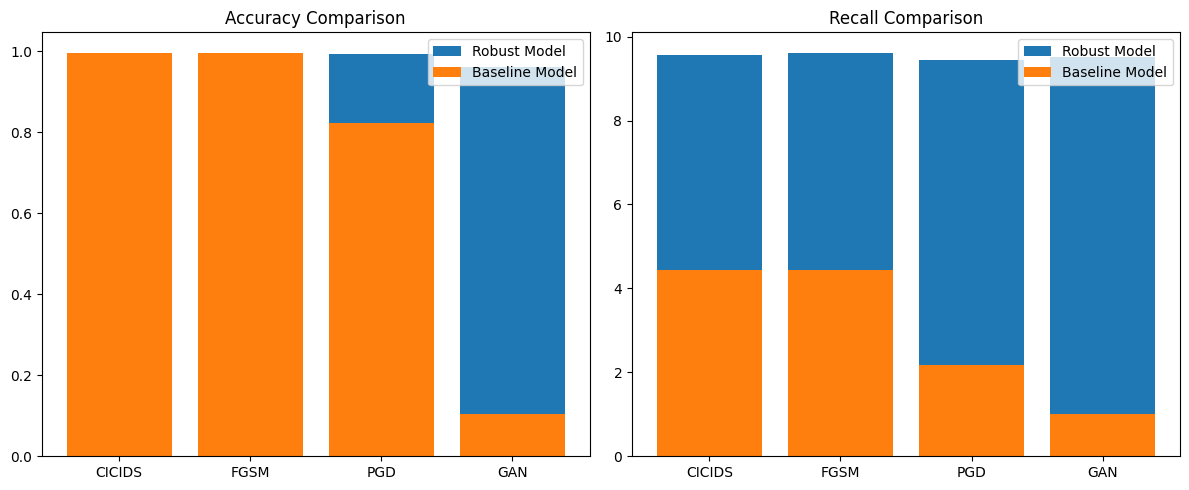

In [ ]:
import matplotlib.pyplot as plt

datasets = ['CICIDS', 'FGSM', 'PGD', 'GAN']

# Accuracy
robust_accuracy = [0.987, 0.986, 0.993, 0.962]
baseline_accuracy = [0.997, 0.996, 0.823, 0.104]

# Recall
robust_recall = [9.55, 9.62, 9.43, 9.51]
baseline_recall = [4.43, 4.43, 2.17, 1.00]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].bar(datasets, robust_accuracy, label='Robust Model')
ax[0].bar(datasets, baseline_accuracy, label='Baseline Model')
ax[0].set_title('Accuracy Comparison')
ax[0].legend()

# Recall
ax[1].bar(datasets, robust_recall, label='Robust Model')
ax[1].bar(datasets, baseline_recall, label='Baseline Model')
ax[1].set_title('Recall Comparison')
ax[1].legend()

plt.tight_layout()
plt.show()